In [1]:
from csromer.simulation import FaradayThickSource, FaradayThinSource
from csromer.reconstruction import Parameter
from csromer.transformers.dfts import NDFT1D, NUFFT1D
from csromer.dictionaries import DiscreteWavelet, UndecimatedWavelet
from csromer.objectivefunction import L1, L2, TSV, TV, Chi2, OFunction
from csromer.optimization import BacktrackingFISTA
from RMtools_1D.do_RMsynth_1D import run_rmsynth, saveOutput
from RMtools_1D.do_RMclean_1D import run_rmclean
from scipy.optimize import minimize_scalar, root_scalar, newton
import numpy as np
import time
import copy
import matplotlib.pyplot as plt
from astropy.stats import mad_std

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rcParams.update(
    {
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.texsystem": 'pdflatex',  # default is xetex
    }
)

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize

In [3]:
def run_csromer(dataset=None, oversampling=8., lambda_l1=0.0, lambda_tsv=0.0):
    __dataset = copy.deepcopy(dataset)
    # __dataset.l2_ref = __dataset.calculate_l2ref()
    parameter = Parameter()
    parameter.calculate_cellsize(dataset=__dataset, oversampling=oversampling)
    
    nufft = NUFFT1D(dataset=__dataset, parameter=parameter)
    dft = NDFT1D(dataset=__dataset, parameter=parameter)
    dirty = dft.backward(__dataset.data)
    rmtf = dft.RMTF()
    
    wav = None
    #wav = DiscreteWavelet(wavelet_name="haar", mode="periodization", append_signal=False)
    #wav = UndecimatedWavelet(wavelet_name="db20", mode="periodization", append_signal=False)
    
    parameter.data = dirty
    parameter.complex_data_to_real()
    if wav is not None:
        parameter.data = wav.decompose(parameter.data)
    
    chi2 = Chi2(dft_obj=nufft, wavelet=wav)
    l1 = L1(reg=lambda_l1) # 0.000025 #0.00005
    tsv = TSV(reg=lambda_tsv)

    F_func = [chi2, l1, tsv]
    f_func = [chi2, tsv]
    g_func = [copy.deepcopy(l1)]

    F_obj = OFunction(F_func)
    f_obj = OFunction(f_func)
    g_obj = OFunction(g_func)
    
    opt = BacktrackingFISTA(
    guess_param=parameter,
    F_obj=F_obj,
    fx=f_obj,
    gx=g_obj,
    max_iter=2000,
    verbose=True
    )

    obj, X = opt.run()
    
    if wav is not None:
        X.data = wav.reconstruct(X.data)
    X.real_data_to_complex() # model
    
    residual = dft.backward(__dataset.residual) #residual
    restored = X.convolve() + residual
    
    return restored, residual, X.data, dirty, parameter

In [4]:
def function_opt(x=0.0, dataset=None, oversampling=8.):
    print("Evaluating {0}".format(x))
    __dataset = copy.deepcopy(dataset)
    parameter = Parameter()
    parameter.calculate_cellsize(dataset=__dataset, oversampling=oversampling)
    
    nufft = NUFFT1D(dataset=__dataset, parameter=parameter)
    dft = NDFT1D(dataset=__dataset, parameter=parameter)
    dirty = dft.backward(__dataset.data)
    rmtf = dft.RMTF()
    
    wav = None
    #wav = DiscreteWavelet(wavelet_name="haar", mode="periodization", append_signal=False)
    #wav = UndecimatedWavelet(wavelet_name="db20", mode="periodization", append_signal=False)
    
    parameter.data = dirty
    parameter.complex_data_to_real()
    if wav is not None:
        parameter.data = wav.decompose(parameter.data)
    
    chi2 = Chi2(dft_obj=nufft, wavelet=wav)
    l1 = L1(reg=x) # 0.000025 #0.00005
    tsv = TSV(reg=0.0)

    F_func = [chi2, l1]
    f_func = [chi2]
    g_func = [copy.deepcopy(l1)]

    F_obj = OFunction(F_func)
    f_obj = OFunction(f_func)
    g_obj = OFunction(g_func)
    
    opt = BacktrackingFISTA(
    guess_param=parameter,
    F_obj=F_obj,
    fx=f_obj,
    gx=g_obj,
    max_iter=2000,
    verbose=True
    )

    obj, X = opt.run()
    
    residual = dft.backward(__dataset.residual)
    
    noise_dirty = 0.5 * (mad_std(dirty[np.abs(parameter.phi) > 0.8 * parameter.max_faraday_depth].real) + mad_std(dirty[np.abs(parameter.phi) > 0.8 * parameter.max_faraday_depth].imag))
    noise = 0.5 * (mad_std(residual.real) + mad_std(residual.imag))
    
    obj_f = np.abs(noise - 5.*noise_dirty)
    
    print("Objective function value: {0}".format(obj_f))
    return obj_f

In [83]:
nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)

In [84]:
thinsource = FaradayThinSource(nu=nu, s_nu=0.035, phi_gal=-200., spectral_idx=0.0)

In [85]:
thicksource = FaradayThickSource(
    nu=nu, s_nu=4*0.035, phi_fg=140., phi_center=200., spectral_idx=0.0
)

In [86]:
thinsource.simulate()
thicksource.simulate()

In [87]:
simsource = thinsource + thicksource

In [88]:
remove_channels_seed = int(time.time())
remove_channels_seed

1688772432

In [89]:
simsource.remove_channels(0.2)

In [90]:
applied_noise = 0.2 * 0.035

In [91]:
simsource.apply_noise(applied_noise)

In [14]:
#sol = minimize_scalar(function_opt, args=(simsource,), tol=1e-12, bounds=(1e-12, 5e-3), method='bounded')
#sol = root_scalar(function_opt, args=(simsource,), xtol=1e-12, rtol=1e-12, x0=1e-12, x1=1)
#sol = newton(func=function_opt, args=(simsource,), tol=1e-12, x0=1e-12, x1=1)

In [15]:
#sol.x

In [100]:
# Create file to read with rmtools-rmclean
data_rmclean = [simsource.nu[::-1], simsource.data.real[::-1], simsource.data.imag[::-1], simsource.sigma[::-1], simsource.sigma[::-1]]

In [98]:
restored, residual, model, dirty, parameter = run_csromer(dataset=simsource, oversampling=8., lambda_l1=0.001, lambda_tsv=0.0)

FWHM of the main peak of the RMTF: 53.955 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 21555.218
Iteration:  0  objective function value: 10611.06055
Iteration:  100  objective function value: 1253.45605
Iteration:  200  objective function value: 882.26392
Convolving with Gaussian kernel where FWHM 53.955 rad/m^2 - pixels 8, sigma 22.913 rad/m^2 - pixels 3


In [101]:
mDict, aDict = run_rmsynth(data=data_rmclean, dPhi_radm2=parameter.cellsize, phiMax_radm2=parameter.max_faraday_depth, super_resolution=True, weightType="variance", noStokesI=True, fitRMSF=False, verbose=True)
saveOutput(mDict, aDict, "test", True)

> Trying [freq_Hz, I, Q, U, dI, dQ, dU] ...failed.
> Trying [freq_Hz, q, u,  dq, du] ... success.
Successfully read in the Stokes spectra.
Warn: no Stokes I data in use.
Plotting the input data and spectral index fit.
Printing here: 18.556427205412167
PhiArr = -21555.22 to 21555.22 by 6.74 (6393 chans).
Weight type is 'variance'.
Running RM-synthesis by channel.


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



  [========================================] 100%
Printing in utils:  53.955490873569744
Calculating 1D RMSF and replicating along X & Y axes.
Printing RMSF after: 53.95549011230469
> RM-synthesis completed in 4.50 seconds.

--------------------------------------------------------------------------------
RESULTS:

FWHM RMSF = 53.96 rad/m^2
Pol Angle = 177.4 (+/-0.1932) deg
Pol Angle 0 = 177.4 (+/-0.1933) deg
Peak FD = -199.3 (+/-0.1819) rad/m^2
freq0_GHz = 1.512 
I freq0 = 1 Jy/beam
Peak PI = 0.03671 (+/-0.0002475) Jy/beam
QU Noise = 0.007 Jy/beam
FDF Noise (theory)   = 0.0002475 Jy/beam
FDF Noise (Corrected MAD) = 0.0003441 Jy/beam
FDF Noise (rms)   = 0.00126 Jy/beam
FDF SNR = 148.3 
sigma_add(q) = 1.743 (+0.05961, -0.05769)
sigma_add(u) = 1.769 (+0.06004, -0.05813)
Fitted polynomial order = 2 

--------------------------------------------------------------------------------
Saving the dirty FDF, RMSF weight arrays to ASCII files.
> test_FDFdirty.dat
> test_RMSF.dat
> test_weight.dat


In [102]:
mDict_cl, aDict_cl = run_rmclean(mDict, aDict, -5.0, verbose=True)

Expected RMS noise = 0.0002475 flux units
Using a sigma cutoff of 5.0.
Absolute value = 0.00124
Cleaning 1/1 spectra.
> RM-CLEAN completed in 0.0469 seconds.    ] 0%

--------------------------------------------------------------------------------
RESULTS:

FWHM RMSF = 53.96 rad/m^2
Pol Angle = 178.7 (+/-0.1385 observed, +- 0.2069 theoretical) deg
Pol Angle 0 = 178.7 (+/-0.1386 observed, +- 0.207 theoretical) deg
Peak FD = -199.3 (+/-0.1305 observed, +- 0.1948 theoretical) rad/m^2
freq0_GHz = 1.512 
I freq0 = 1 Jy/beam
Peak PI = 0.03427 (+/-0.0001657 observed, +- 0.0002475 theoretical) Jy/beam
QU Noise = 0.007 Jy/beam
FDF Noise (theory)   = 0.0002475 Jy/beam
FDF Noise (Corrected MAD) = 0.0001657 Jy/beam
FDF Noise (rms)   = 0.0005345 Jy/beam
FDF SNR = 138.5 

--------------------------------------------------------------------------------


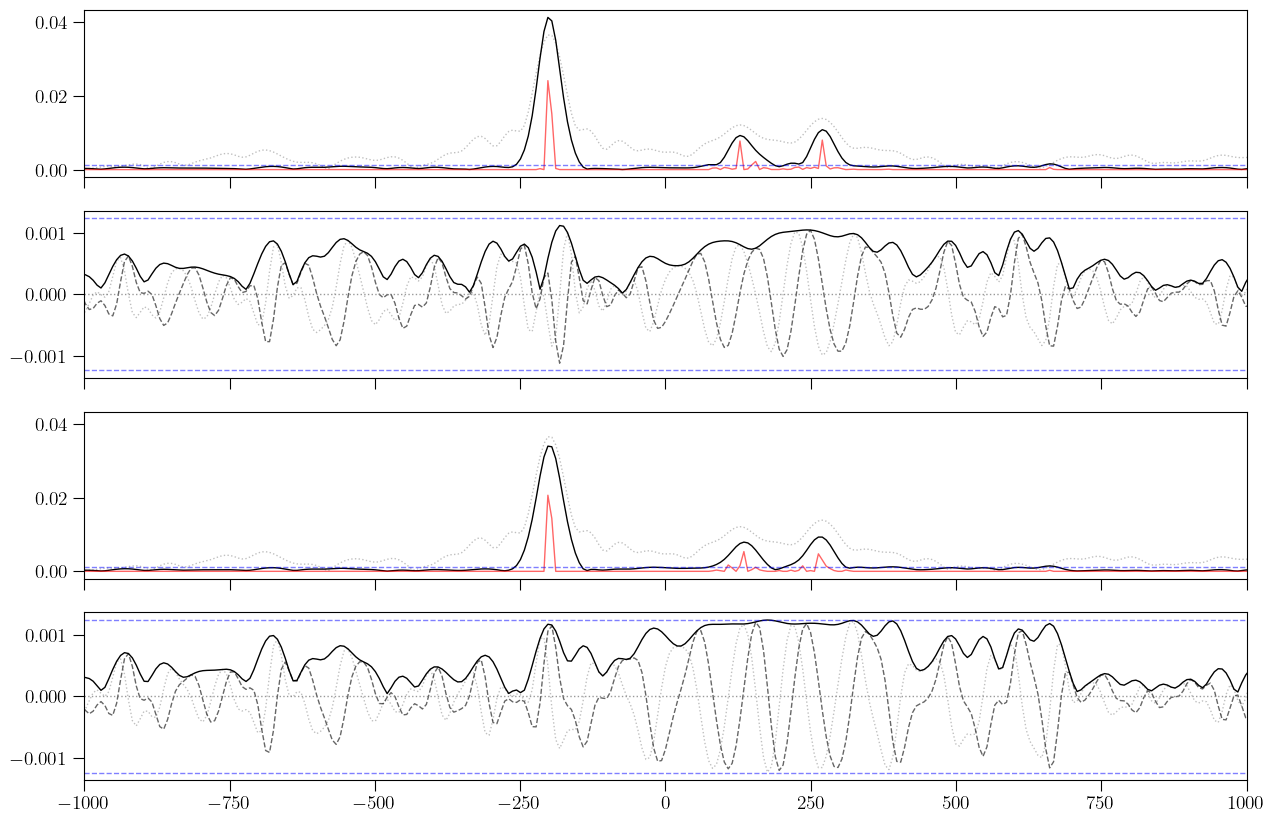

In [103]:
fig, ax = plt.subplots(figsize=(15,10), nrows=4,ncols=1, sharex=True, sharey=False)

ax[0].plot(parameter.phi, np.abs(restored), "k-", label=r'Restored $|P|$')
ax[0].plot(parameter.phi, np.abs(model) / (parameter.rmtf_fwhm/parameter.cellsize), color="red", alpha=0.6, label=r'Model $|P|$')
ax[0].plot(parameter.phi, np.abs(dirty), "k:", alpha=0.25, label=r'Dirty $|P|$')
ax[0].axhline(y=5*simsource.theo_noise, color='blue', linestyle="--", alpha=0.5, label=r"5$\sigma$ = {0:0.2f} $\mu$Jy beam$^{1}$ rmtf$^{2}$".format(5*simsource.theo_noise, "{-1}", "{-1}"))
#ax[0].axvline(x=reconstructor.rm_dirty_quadratic_interpolation, color='black', linestyle="--", alpha=0.25, label=r"$\phi_{0} = {1:0.2f} \pm {2:0.2f}$ [rad m$^{3}$]".format(r"{\rm peak}", reconstructor.rm_dirty_quadratic_interpolation, reconstructor.rm_dirty_quadratic_interpolation_error, "{-2}"))
ax[0].set_xlim([-1000, 1000])

ax[1].plot(parameter.phi, np.abs(residual), "k-", label=r'Residual $|P|$')
ax[1].plot(parameter.phi, residual.real, "k--", alpha=0.6, label=r'Residual $Q$')
ax[1].plot(parameter.phi, residual.imag, "k:", alpha=0.25, label=r'Residual $U$')
ax[1].axhline(y=5*simsource.theo_noise, color='blue', linestyle="--", alpha=0.5, label=r"5$\sigma$ = {0:0.2f} $\mu$Jy beam$^{1}$ rmtf$^{2}$".format(5*simsource.theo_noise, "{-1}", "{-1}"))
ax[1].axhline(y=-5*simsource.theo_noise, color='blue', linestyle="--", alpha=0.5, label=r"5$\sigma$ = {0:0.2f} $\mu$Jy beam$^{1}$ rmtf$^{2}$".format(5*simsource.theo_noise, "{-1}", "{-1}"))
ax[1].set_xlim([-1000, 1000])
ax[1].axhline(y=0, color='grey', linestyle=":", alpha=0.8)
#ax[1].set_ylim([-5*simsource.theo_noise , 5*simsource.theo_noise])

ax[2].plot(aDict_cl['phiArr_radm2'], np.abs(aDict_cl['cleanFDF']), "k-", label=r'Restored $|P|$')
ax[2].plot(aDict_cl['phiArr_radm2'], np.abs(aDict_cl['ccArr']), color="red", alpha=0.6, label=r'Model $|P|$')
ax[2].plot(aDict['phiArr_radm2'], np.abs(aDict['dirtyFDF']), "k:", alpha=0.25, label=r'Dirty $|P|$')
ax[2].axhline(y=5*simsource.theo_noise, color='blue', linestyle="--", alpha=0.5, label=r"5$\sigma$ = {0:0.2f} $\mu$Jy beam$^{1}$ rmtf$^{2}$".format(5*simsource.theo_noise, "{-1}", "{-1}"))
ax[2].set_xlim([-1000, 1000])

ax[3].plot(aDict_cl['phiArr_radm2'], np.abs(aDict_cl['residFDF']), "k-", label=r'Restored $|P|$')
ax[3].plot(aDict_cl['phiArr_radm2'], aDict_cl['residFDF'].real, "k--", alpha=0.6, label=r'Model $|P|$')
ax[3].plot(aDict['phiArr_radm2'], aDict_cl['residFDF'].imag, "k:", alpha=0.25, label=r'Dirty $|P|$')
ax[3].axhline(y=5*simsource.theo_noise, color='blue', linestyle="--", alpha=0.5, label=r"5$\sigma$ = {0:0.2f} $\mu$Jy beam$^{1}$ rmtf$^{2}$".format(5*simsource.theo_noise, "{-1}", "{-1}"))
ax[3].axhline(y=-5*simsource.theo_noise, color='blue', linestyle="--", alpha=0.5, label=r"5$\sigma$ = {0:0.2f} $\mu$Jy beam$^{1}$ rmtf$^{2}$".format(5*simsource.theo_noise, "{-1}", "{-1}"))
#ax[0].axvline(x=reconstructor.rm_dirty_quadratic_interpolation, color='black', linestyle="--", alpha=0.25, label=r"$\phi_{0} = {1:0.2f} \pm {2:0.2f}$ [rad m$^{3}$]".format(r"{\rm peak}", reconstructor.rm_dirty_quadratic_interpolation, reconstructor.rm_dirty_quadratic_interpolation_error, "{-2}"))
ax[3].set_xlim([-1000, 1000])
ax[3].axhline(y=0, color='grey', linestyle=":", alpha=0.8)


ax[2].sharey(ax[0])


In [21]:
np.max(np.abs(aDict_cl['ccArr']))

0.030316802

In [22]:
np.max(np.abs(model) / (parameter.rmtf_fwhm/parameter.cellsize))

0.021896778